In [16]:
#Import relevant libraries

import pandas as pd
import numpy as np
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [6]:
# Use API to download dataset from Kaggle

api = KaggleApi()
api.authenticate()
dataset_id = 'eavannan/daftie-house-price-data'
save_path = '.'
api.dataset_download_files(dataset_id, path=save_path, unzip=True)


In [17]:
df_daft_data = pd.read_csv('daft_ie_v1.csv')

In [3]:
df_daft_data.head()

,id,title,featuredLevel,publishDate,price,numBedrooms,numBathrooms,propertyType,propertySize,category,...,seller_name,seller_branch,sellerType,m_totalImages,m_hasVideo,m_hasVirtualTour,m_hasBrochure,ber_rating,longitude,latitude
0,3626025,"11 Chestnut Crescent, Bridgemount, Carrigaline...",featured,2022-01-28,290000,3,3,End of Terrace,96.0,Buy,...,Roy Dennehy,Dennehy Auctioneers,BRANDED_AGENT,16.0,False,False,False,C2,-8.382500,51.822940
1,3675175,"58 The Glen, Kilnacourt Woods, Portarlington, ...",featured,2022-01-28,225000,3,2,Semi-D,93.0,Buy,...,Marie Kiernan,Tom McDonald & Associates,BRANDED_AGENT,33.0,False,False,False,C1,-7.177098,53.157465
2,3673450,"16 Dodderbrook Park, Ballycullen, Dublin 24",featured,2022-01-27,575000,4,3,Semi-D,162.0,Buy,...,Moovingo,Moovingo,BRANDED_AGENT,38.0,False,True,False,A3,-6.342763,53.269493
3,3649708,"31 Lissanalta Drive, Dooradoyle, Co. Limerick",featured,2022-01-28,299000,3,3,Semi-D,NaN,Buy,...,DNG Cusack Dunne,DNG Cusack Dunne,BRANDED_AGENT,22.0,False,False,False,C2,-8.640716,52.629588
4,3643947,"5 Columba Terrace, Kells, Co. Meath",featured,2022-01-28,120000,3,1,Terrace,68.0,Buy,...,REA T&J Gavigan,REA T & J Gavigan,BRANDED_AGENT,5.0,False,False,False,G,-6.879797,53.728601


In [18]:
# Create a new dataframe, extract the id and county, then merge them back into the main dataframe

df_county_extract = pd.DataFrame({'id': df_daft_data['id'], 'county': None})

# Iterate over each row in df_daft_data
for index, row in df_daft_data.iterrows():
    title = row['title']
    
    # Extract characters after the final comma
    pattern = r",([^,]*)$"
    result = re.search(pattern, title)
    
    if result:
        county = result.group(1)
        df_county_extract.at[index, 'county'] = county

# Strip out the leading whitespace
df_county_extract['county'] = df_county_extract['county'].str.strip()

In [19]:

df_county_extract.head()

,id,county
0,3626025,Co. Cork
1,3675175,Co. Laois
2,3673450,Dublin 24
3,3649708,Co. Limerick
4,3643947,Co. Meath


In [22]:
# Print out the list of values for County as a visual check

sorted(df_county_extract['county'].unique())

# As Dublin is large I'll keep the division by postcode and treat each as a county

['Co. Carlow',
 'Co. Cavan',
 'Co. Clare',
 'Co. Cork',
 'Co. Donegal',
 'Co. Dublin',
 'Co. Galway',
 'Co. Kerry',
 'Co. Kildare',
 'Co. Kilkenny',
 'Co. Laois',
 'Co. Leitrim',
 'Co. Limerick',
 'Co. Longford',
 'Co. Louth',
 'Co. Mayo',
 'Co. Meath',
 'Co. Monaghan',
 'Co. Offaly',
 'Co. Roscommon',
 'Co. Sligo',
 'Co. Tipperary',
 'Co. Waterford',
 'Co. Westmeath',
 'Co. Wexford',
 'Co. Wicklow',
 'Dublin 1',
 'Dublin 10',
 'Dublin 11',
 'Dublin 12',
 'Dublin 13',
 'Dublin 14',
 'Dublin 15',
 'Dublin 16',
 'Dublin 17',
 'Dublin 18',
 'Dublin 2',
 'Dublin 20',
 'Dublin 22',
 'Dublin 24',
 'Dublin 3',
 'Dublin 4',
 'Dublin 5',
 'Dublin 6',
 'Dublin 6W',
 'Dublin 7',
 'Dublin 8',
 'Dublin 9']

In [21]:
# Do a manual search and replace for the entries where the county info is missing
# I could have just dropped the rows where 'county' was not in the list of actual counties
# but as there were not many I kept them in by manually changing the values

df_county_extract['county'] = df_county_extract['county'].str.replace('Ballinahowen', 'Co. Westmeath')
df_county_extract['county'] = df_county_extract['county'].str.replace('Ballinasloe', 'Co. Galway')
df_county_extract['county'] = df_county_extract['county'].str.replace('Castledaly', 'Co. Westmeath')
df_county_extract['county'] = df_county_extract['county'].str.replace('Charleville', 'Co. Cork')
df_county_extract['county'] = df_county_extract['county'].str.replace('Connemara', 'Co. Galway')
df_county_extract['county'] = df_county_extract['county'].str.replace('Ferrybank', 'Co. Waterford')
df_county_extract['county'] = df_county_extract['county'].str.replace('Lee Road', 'Co. Cork')
df_county_extract['county'] = df_county_extract['county'].str.replace('Lehenaghbeg', 'Co. Cork')
df_county_extract['county'] = df_county_extract['county'].str.replace('Longford', 'Co. Longford')
df_county_extract['county'] = df_county_extract['county'].str.replace('Northern Cross', 'Dublin 17')
df_county_extract['county'] = df_county_extract['county'].str.replace('Our Ladys Island', 'Co. Wexford')
df_county_extract['county'] = df_county_extract['county'].str.replace('Shannonbanks', 'Co. Limerick')
df_county_extract['county'] = df_county_extract['county'].str.replace('The Ward', 'Co. Dublin')
df_county_extract['county'] = df_county_extract['county'].str.replace('Waterford', 'Co. Waterford')
df_county_extract['county'] = df_county_extract['county'].str.replace('Youghal', 'Co. Cork')

# This fixes the places where the above code duplicates the Co. It is kinda kludgy but it works

df_county_extract['county'] = df_county_extract['county'].str.replace('Co. Co. Longford', 'Co. Longford', regex=True)
df_county_extract['county'] = df_county_extract['county'].str.replace('Co. Co. Waterford', 'Co. Waterford', regex=True)

In [24]:
# Merge the new county values into the main dataframe

df_daft_data = pd.merge(df_daft_data, df_county_extract, on='id')


In [26]:
df_daft_data.shape

(3967, 23)

In [39]:
# I'm going to create some bar graphs to get a handle on the different fields, so create a function as I'll
# be doing the same thing over again

# I will pass the field name to thig function and it will return a bar graph

def plot_bar_chart(column_name):
    # Get the property counts of the column
    property_counts = df_daft_data[column_name].value_counts()

    # Create the bar plot
    plt.bar(property_counts.index, property_counts.values)

    # Set labels and title
    plt.xlabel(column_name)
    plt.ylabel('Property Count')
    plt.title('Prevalence of ' + column_name)

    # Rotate x-axis labels and reduce label size
    plt.xticks(rotation=90)
    plt.tick_params(axis='x', which='major', labelsize=6)

    # Display the plot
    plt.show()

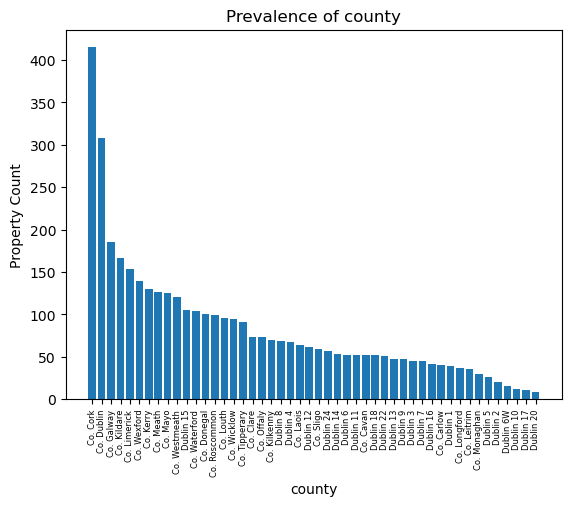

In [40]:
# How many properties in each county

plot_bar_chart('county')

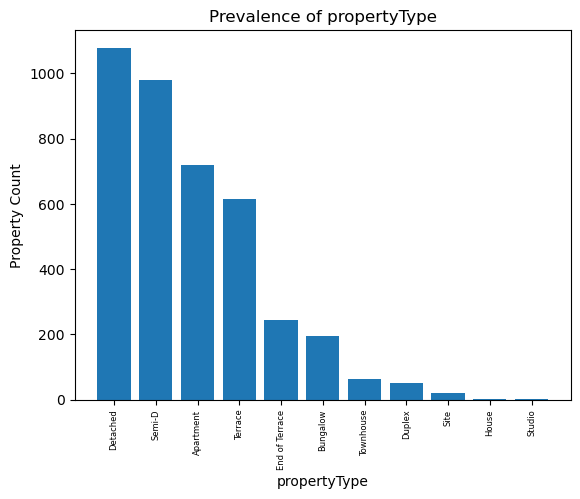

In [41]:
plot_bar_chart('propertyType')

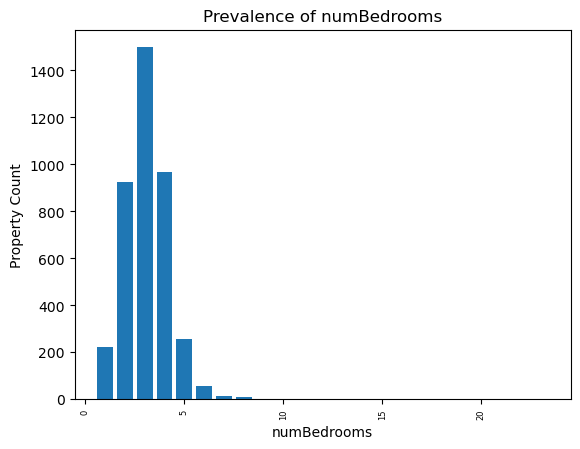

In [42]:
plot_bar_chart('numBedrooms')

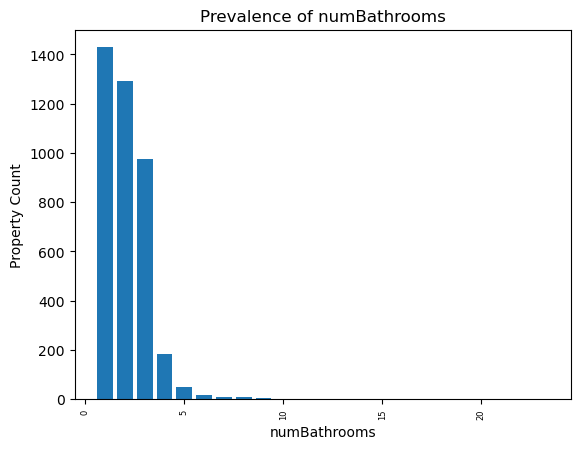

In [43]:
plot_bar_chart('numBathrooms')

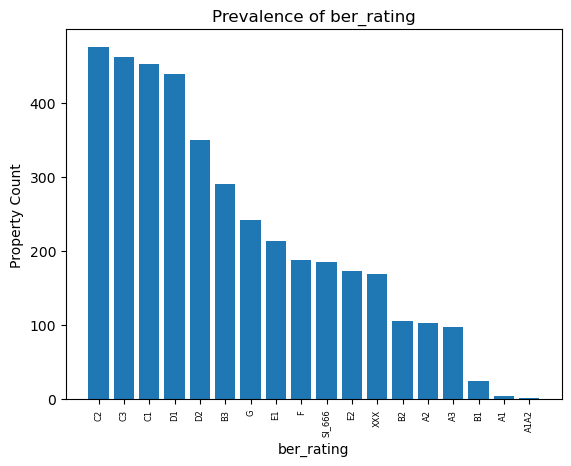

In [44]:
plot_bar_chart('ber_rating')

In [47]:
# create a function to plot graphs of avg price

def avg_price_graph(column_name):
    # Get the property counts of the column
    avg_prices = df_daft_data.groupby(column_name)['price'].mean()
    avg_prices = avg_prices.sort_values(ascending=False)

    # Create the bar plot
    avg_prices.plot(kind='bar')
    
    # Set labels and title
    plt.xlabel(column_name)
    plt.ylabel('Avg Price')
    plt.title('Avg Price of ' + column_name)
    
    # Rotate x-axis labels and reduce label size
    plt.xticks(rotation=90)
    plt.tick_params(axis='x', which='major', labelsize=6)

    # Display the plot
    plt.show()


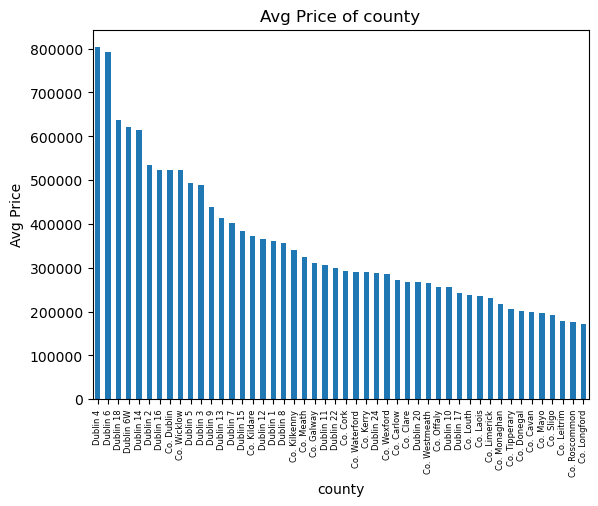

In [48]:
avg_price_graph('county')

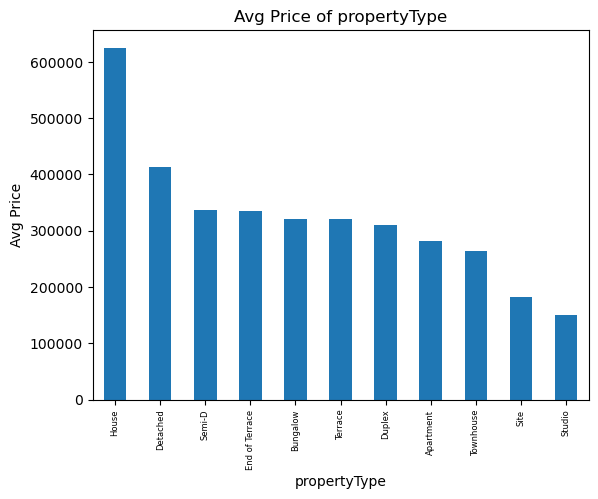

In [49]:
avg_price_graph('propertyType')

In [35]:
# check for missing values
print(df_daft_data.isna().sum().sort_values())

id                  0
longitude           0
ber_rating          0
m_hasBrochure       0
m_hasVirtualTour    0
m_hasVideo          0
m_totalImages       0
sellerType          0
seller_branch       0
seller_name         0
latitude            0
sellerId            0
category            0
propertySize        0
propertyType        0
numBathrooms        0
numBedrooms         0
price               0
publishDate         0
featuredLevel       0
title               0
AMV_price           0
county              0
dtype: int64


In [34]:
# propertySize has 355 missing values - this is over 10% of the total rows. Therefore better to replace these values
# rather than just delete these rows, as otherwise we lose the data from the other columns for the modelling

# I will replace with the median value of the column

median_property_size = df_daft_data['propertySize'].median()

df_daft_data['propertySize'].fillna(median_property_size, inplace=True)

           id                                              title  \
0     3626025  11 Chestnut Crescent, Bridgemount, Carrigaline...   
1     3675175  58 The Glen, Kilnacourt Woods, Portarlington, ...   
2     3673450        16 Dodderbrook Park, Ballycullen, Dublin 24   
3     3649708      31 Lissanalta Drive, Dooradoyle, Co. Limerick   
4     3643947                5 Columba Terrace, Kells, Co. Meath   
...       ...                                                ...   
3962  3644416              13 Cherry Close, Bellfield, Waterford   
3963  3644275               8 Thomas Street, Castlebar, Co. Mayo   
3964  3644111         69 McAuley Drive, Artane, Artane, Dublin 5   
3965  3644099              School Land, Ballinalee, Co. Longford   
3966  3603137  14 Coolmagort Ave, Beaufort, Killarney, Co. Kerry   

     featuredLevel publishDate   price  numBedrooms  numBathrooms  \
0         featured  2022-01-28  290000            3             3   
1         featured  2022-01-28  225000       

In [36]:
# recheck for missing values
print(df_daft_data.isna().sum().sort_values())

id                  0
longitude           0
ber_rating          0
m_hasBrochure       0
m_hasVirtualTour    0
m_hasVideo          0
m_totalImages       0
sellerType          0
seller_branch       0
seller_name         0
latitude            0
sellerId            0
category            0
propertySize        0
propertyType        0
numBathrooms        0
numBedrooms         0
price               0
publishDate         0
featuredLevel       0
title               0
AMV_price           0
county              0
dtype: int64


In [97]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [104]:
# Define the input features (X) and the target variable (y)
features = ['numBedrooms', 'numBathrooms', 'propertyType', 'propertySize',  'county']
target = 'price'

# Encode categorical features
label_encoder = LabelEncoder()
for feature in ['county', 'propertyType', 'ber_rating']:
    df_daft_data[feature] = label_encoder.fit_transform(df_daft_data[feature])

# Split the data into training and testing sets
X = df_daft_data[features]
y = df_daft_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)


# Create a random forest regressor model and fit it to the training data
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 29513210902.369682


In [108]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [110]:
# Select features and target variable
features = ['numBedrooms', 'numBathrooms', 'propertyType', 'propertySize',  'county', 'ber_rating']
target = 'price'

# Split the data into training and testing sets
X = df_daft_data[features]
y = df_daft_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost model
model = xgb.XGBRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 29630891961.449074
